# World Wide Products Inc.

__Problem Statement__: Build the forecasting models to determine the demand of a particular product

__Dataset__: Data set contains the product demands for encoded products
<br>
Source: https://www.kaggle.com/felixzhao/productdemandforecasting

__Reference__: https://pythondata.com/forecasting-time-series-data-with-prophet-part-1/

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from fbprophet import Prophet
import numpy as np
warnings.filterwarnings('ignore') # specify to ignore warning messages

## Data Extraction and Feature Engineering

In [2]:
demand = pd.read_csv('../data/external/Historical Product Demand.csv', low_memory=False)
list(demand)

['Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand']

In [3]:
demand.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,7/27/12,100
1,Product_0979,Whse_J,Category_028,1/19/12,500
2,Product_0979,Whse_J,Category_028,2/3/12,500
3,Product_0979,Whse_J,Category_028,2/9/12,500
4,Product_0979,Whse_J,Category_028,3/2/12,500


In [4]:
# Check if there are any columns with null values
demand.isna().any()

Product_Code        False
Warehouse           False
Product_Category    False
Date                 True
Order_Demand        False
dtype: bool

In [5]:
# Drop NAs
demand = demand.dropna(how='any',axis=0) 

In [6]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 5 columns):
Product_Code        1037336 non-null object
Warehouse           1037336 non-null object
Product_Category    1037336 non-null object
Date                1037336 non-null object
Order_Demand        1037336 non-null int64
dtypes: int64(1), object(4)
memory usage: 47.5+ MB


In [7]:
demand.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,7/27/12,100
1,Product_0979,Whse_J,Category_028,1/19/12,500
2,Product_0979,Whse_J,Category_028,2/3/12,500
3,Product_0979,Whse_J,Category_028,2/9/12,500
4,Product_0979,Whse_J,Category_028,3/2/12,500


In [8]:
demand.Product_Code.unique()

array(['Product_0993', 'Product_0979', 'Product_1159', ...,
       'Product_0237', 'Product_0644', 'Product_0853'], dtype=object)

In [9]:
## Which product has maximum demand?

In [10]:
demand.groupby("Product_Code").sum().sort_values("Order_Demand", ascending=False).head(1)

,Order_Demand
Product_Code,
Product_1359,470710000


In [11]:
## Which product has least demand?

In [12]:
demand.groupby("Product_Code").sum().sort_values("Order_Demand", ascending=False).tail(1)

,Order_Demand
Product_Code,
Product_1703,2


In [13]:
## Which warehouse has maximum demand?

In [14]:
demand.groupby("Warehouse").sum().sort_values("Order_Demand", ascending=False).head(5)

,Order_Demand
Warehouse,
Whse_J,3344521718
Whse_S,1034227618
Whse_C,581845212
Whse_A,143257683


In [15]:
demand.groupby("Product_Category").sum().sort_values("Order_Demand", ascending=False).head(5)

,Order_Demand
Product_Category,
Category_019,4219806665
Category_006,401649668
Category_005,198361890
Category_007,127725843
Category_028,47276346


In [ ]:
##Picking the product with most order demand

In [16]:
product = demand.loc[demand['Product_Code'] == 'Product_1359']

In [17]:
product['Date'].min(), product['Date'].max()

('1/10/12', '9/9/16')

In [18]:
product.head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
276,Product_1359,Whse_J,Category_019,4/18/12,80000
282,Product_1359,Whse_J,Category_019,5/21/12,70000
289,Product_1359,Whse_J,Category_019,6/26/12,80000
292,Product_1359,Whse_J,Category_019,7/17/12,100000
296,Product_1359,Whse_J,Category_019,8/24/12,100000


In [19]:
product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16936 entries, 276 to 1046518
Data columns (total 5 columns):
Product_Code        16936 non-null object
Warehouse           16936 non-null object
Product_Category    16936 non-null object
Date                16936 non-null object
Order_Demand        16936 non-null int64
dtypes: int64(1), object(4)
memory usage: 793.9+ KB


In [20]:
product = product.drop(columns=['Warehouse','Product_Category','Product_Code'])

In [21]:
product.head(5)

,Date,Order_Demand
276,4/18/12,80000
282,5/21/12,70000
289,6/26/12,80000
292,7/17/12,100000
296,8/24/12,100000


In [22]:
product.isnull().sum()

Date            0
Order_Demand    0
dtype: int64

In [23]:
productnew = product.copy()

In [24]:
productnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16936 entries, 276 to 1046518
Data columns (total 2 columns):
Date            16936 non-null object
Order_Demand    16936 non-null int64
dtypes: int64(1), object(1)
memory usage: 396.9+ KB


In [25]:
productnew.head()

,Date,Order_Demand
276,4/18/12,80000
282,5/21/12,70000
289,6/26/12,80000
292,7/17/12,100000
296,8/24/12,100000


In [26]:
productnew = productnew.rename(columns={'Date': 'ds', 'Order_Demand': 'y'})

In [27]:
productnew.head(5)

,ds,y
276,4/18/12,80000
282,5/21/12,70000
289,6/26/12,80000
292,7/17/12,100000
296,8/24/12,100000


## Time Series using FBProphet

In [28]:
model = Prophet() #instantiate Prophet
model.fit(productnew); #fit the model with your dataframe

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
future_data = model.make_future_dataframe(periods=365)

In [30]:
forecast_data = model.predict(future_data)

In [31]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
17296,2018-01-02,34497.992882,-56427.972138,120977.268329
17297,2018-01-03,31073.796349,-53175.811421,118418.067413
17298,2018-01-04,27467.529933,-53868.226319,121500.825189
17299,2018-01-05,28868.671484,-56629.651541,115591.367763
17300,2018-01-06,4642.653084,-87807.334516,90171.254982


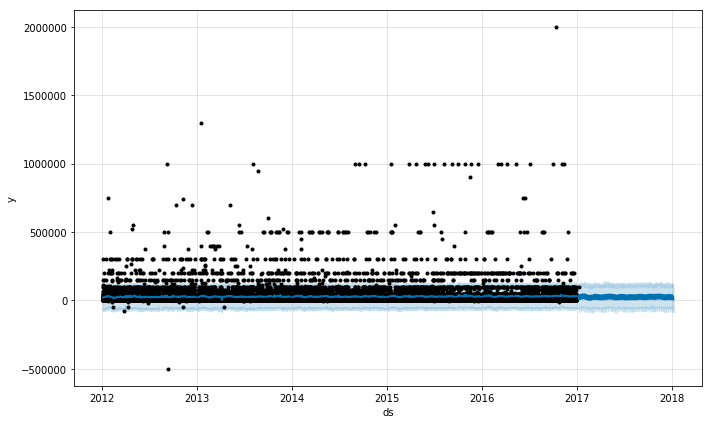

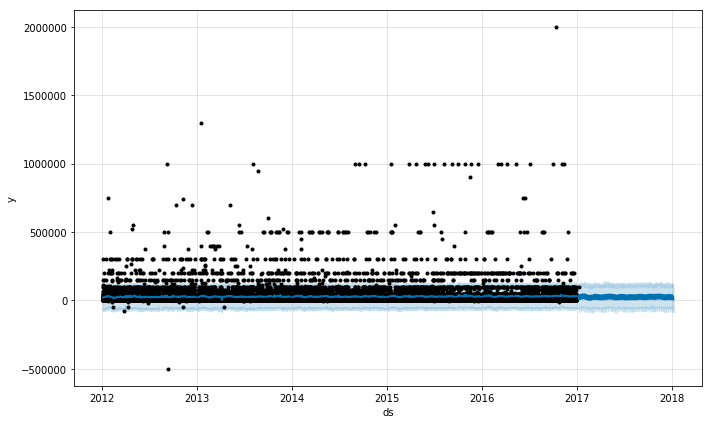

In [32]:
model.plot(forecast_data)

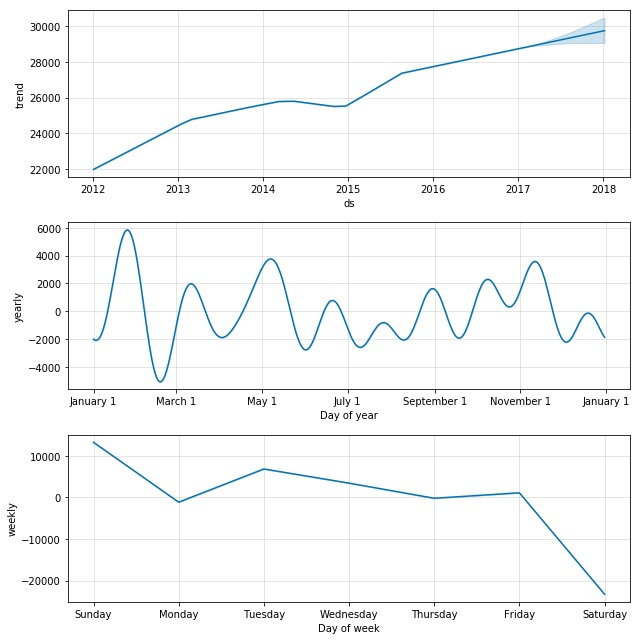

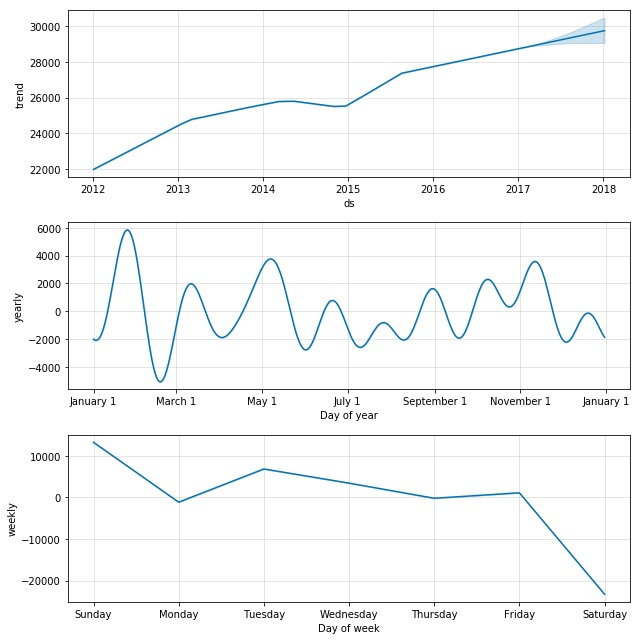

In [33]:
model.plot_components(forecast_data)

__Conclusion__: From the plots, this can be observed that the trend of order demand over the next year is still going high for the product which currently has highest demand. It can also be observed that although the demand is almost consistent through the week, it takes a huge dip on Saturday, and then takes a leep on Sunday. As far as months are concerned, demand shows no particular consistency, and takes a lot of ups and downs. Though there is a huge dip during the month of February.